In [ ]:
from google.colab import drive
drive.mount('/content/drive')

--2024-11-16 09:01:42--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-11-16 09:01:42 (82.8 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2024-11-16 09:01:42--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘coco.names’

coco

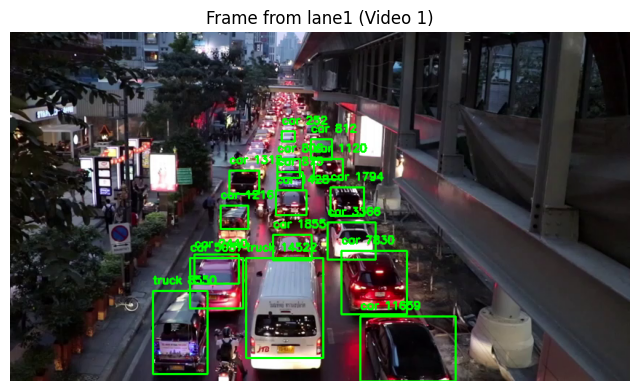

Total area of detected vehicles in lane2: 65635 pixels^2


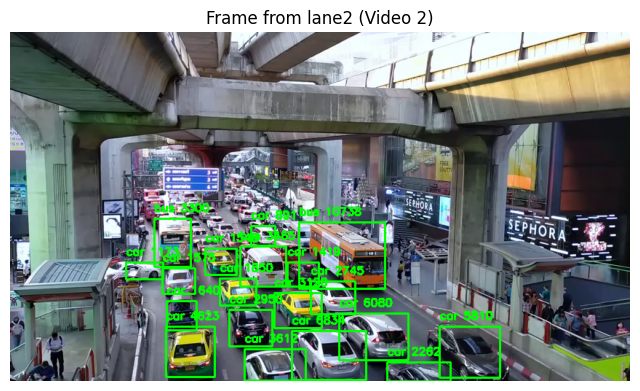

Total area of detected vehicles in lane3: 12345 pixels^2


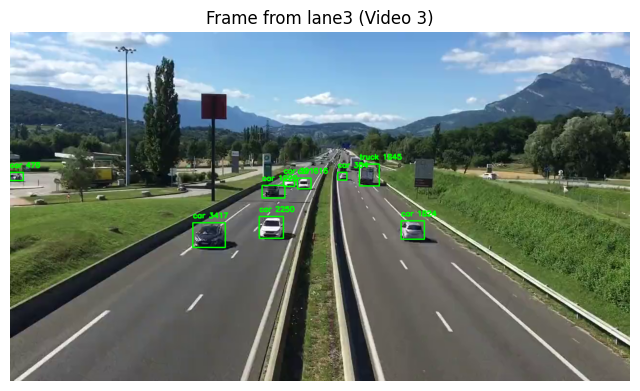

Sorted total areas for each lane: {'lane2': 65635, 'lane1': 64874, 'lane3': 12345}
New order after processing shared_previous_cycle: ['lane2', 'lane1', 'lane3']
NORMAL CYCLE GREEN FOR lane2 ...
Timer: 12 seconds

0: 384x640 (no detections), 10.7ms
Speed: 4.2ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.4ms
Speed: 4.1ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.1ms
Speed: 3.7ms preprocess, 11.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 3.7ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.8ms
Speed: 4.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 

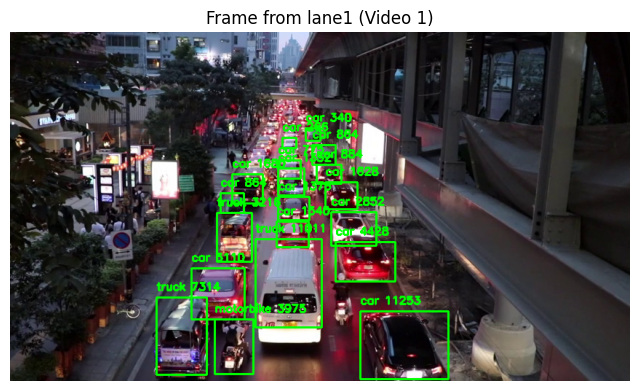

Total area of detected vehicles in lane2: 151504 pixels^2

0: 384x640 1 ambulance, 33.6ms
Speed: 4.0ms preprocess, 33.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
EMERGENCY FUNCTION : Ambulance detected in lane 1 at time: 0.10 seconds


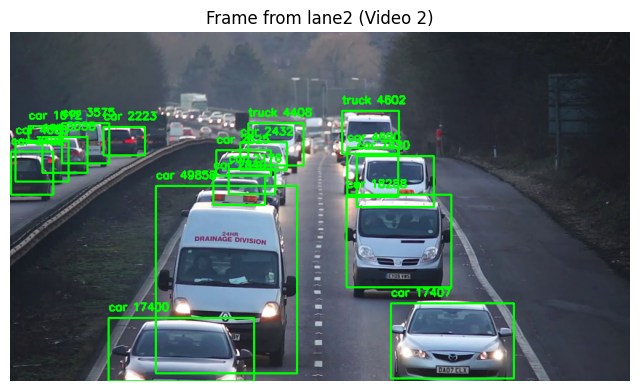

Total area of detected vehicles in lane3: 16730 pixels^2


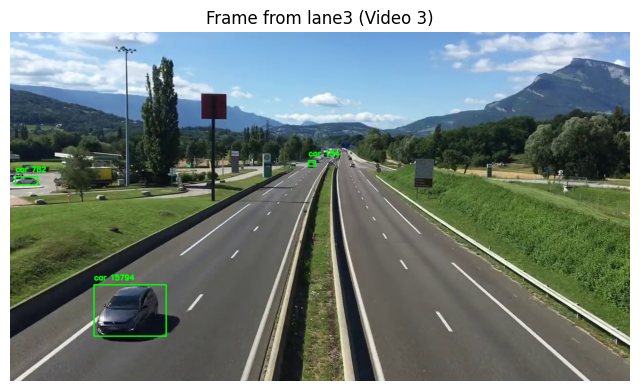

Sorted total areas for each lane: {'lane2': 151504, 'lane1': 60708, 'lane3': 16730}
New order after processing shared_previous_cycle: ['lane2', 'lane1', 'lane3']
NORMAL CYCLE GREEN FOR lane2 ...
Timer: 15 seconds
NORMAL CYCLE : ambulance is passing...
NORMAL CYCLE : ambulance is passing...
NORMAL CYCLE : ambulance is passing...
NORMAL CYCLE : ambulance is passing...
NORMAL CYCLE : ambulance is passing...

0: 384x640 (no detections), 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
NORMAL_CYCLE : ambulance passed comes to normal rotation...
NORMAL CYCLE : Time's up! for  lane2 ...
NORMAL CYCLE GREEN FOR lane2 ...
Timer: 15 seconds
NORMAL CYCLE : Time's up! for  lane2 ...
NORMAL CYCLE GREEN FOR lane3 ...
Timer: 10 seconds
NORMAL CYCLE : Time's up! for  lane3 ...
previous_cycle list :  ['lane1', 'lane2', 'lane3']
NORMAL CYCLE : CYCLE ENDS...
NORMAL CYCLE : CYCLE STARTS...


Process Process-5:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-ec02d8725674>", line 275, in vehicle_detection
    frames = [extract_frame_at_time(vc, previous_time_passed) for vc in video_captures]
  File "<ipython-input-3-ec02d8725674>", line 275, in <listcomp>
    frames = [extract_frame_at_time(vc, previous_time_passed) for vc in video_captures]
  File "<ipython-input-3-ec02d8725674>", line 249, in extract_frame_at_time
    raise Exception(f"Could not read frame at {time_in_seconds} seconds from video")
Exception: Could not read frame at 97.65982031822205 seconds from video


In [ ]:
!pip install opencv-python opencv-python-headless
#!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names
!pip install ultralytics opencv-python-headless


import multiprocessing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import asyncio
from ultralytics import YOLO

weights_path = '/content/drive/MyDrive/Dataset/yolov3 (2).weights'
cfg_path = '/content/drive/MyDrive/Dataset/yolov3.cfg'
coco_names_path = '/content/drive/MyDrive/Dataset/coco.names'


yolov8_model_path = '/content/drive/MyDrive/Dataset/best.pt'  # Update this path
yolov8_model = YOLO(yolov8_model_path)
net = cv2.dnn.readNet(weights_path, cfg_path)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

with open(coco_names_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

previous_cycle = []
sorted_keys = []
new_order = []

async def process_video(cap, lane_number, shared_ambulance_detected, shared_current_detector, shared_new_order, shared_previous_cycle):
    video_path = f"lane {lane_number}"

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    detection_delay = 10
    non_detection_delay = 5
    new_frame_pos = 0

    while cap.isOpened():
        current_frame_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
        current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # Get current time in seconds
        ret, frame = cap.read()
        if not ret:
            break

        while shared_ambulance_detected.value and shared_current_detector.value != lane_number:
            await asyncio.sleep(1)

        results = yolov8_model(frame)
        detected_ambulance = False

        for result in results:
            if result.boxes:
                detected_ambulance = True
                break

        while detected_ambulance:
            shared_ambulance_detected.value = True
            shared_current_detector.value = lane_number
            print(f"EMERGENCY FUNCTION : Ambulance detected in {video_path} at time: {current_time:.2f} seconds")

            await asyncio.sleep(detection_delay)

            ret, frame = cap.read()
            results = yolov8_model(frame)
            detected_ambulance = False

            for result in results:
                if result.boxes:
                    detected_ambulance = True
                    break

            if not detected_ambulance:
                # Reset shared flags if no ambulance is detected
                #print("previous_cycle before due to ambulance detection",shared_previous_cycle)
                #print("new_order due before to ambulance detection",shared_new_order)
                #print("hello")
                lane_remove="lane"+str(lane_number)
                if(lane_remove in shared_previous_cycle):
                    shared_previous_cycle.remove(lane_remove)
                shared_previous_cycle.append(lane_remove)
                if(lane_remove in shared_new_order):
                    shared_new_order.remove(lane_remove)
                shared_ambulance_detected.value = False
                shared_current_detector.value = -1
                #print(f"No ambulance detected in {video_path}. Resuming normal processing.")
                #print("previous_cycle due to ambulance detection",shared_previous_cycle)
                #print("new_order due to ambulance detection",shared_new_order)
                detected_ambulance = False

            else:
                print("EMERGENCY FUNCTION : ambulance detected again")



            new_frame_pos += int(fps * (current_time + detection_delay))
            cap.set(cv2.CAP_PROP_POS_FRAMES, new_frame_pos)
        else:
            await asyncio.sleep(non_detection_delay)
            new_frame_pos += int(fps * (current_time + non_detection_delay))
            cap.set(cv2.CAP_PROP_POS_FRAMES, new_frame_pos)

    cap.release()


async def ambulance_detection(shared_ambulance_detected, shared_current_detector, shared_new_order, shared_previous_cycle):
    video_paths = [
        "/content/drive/MyDrive/Dataset/ambulance_sample_black_2.mp4",
        "/content/drive/MyDrive/Dataset/ambulance_sample_black_1.mp4"
    ]

    video_captures = [cv2.VideoCapture(video_path) for video_path in video_paths]

    await asyncio.gather(
        *[process_video(cap, idx + 1, shared_ambulance_detected, shared_current_detector, shared_new_order, shared_previous_cycle) for idx, cap in enumerate(video_captures)]
    )

def run_async_function(shared_new_order, shared_previous_cycle, shared_ambulance_detected, shared_current_detector):
    asyncio.run(ambulance_detection(shared_ambulance_detected, shared_current_detector, shared_new_order, shared_previous_cycle))


def countdown_timer(seconds, lane, pixel_area,previous_cycle,shared_new_order,shared_ambulance_detected):
    print("NORMAL CYCLE GREEN FOR",lane,"...")
    print(f"Timer: {seconds} seconds")

    check_seconds = seconds
    is_popped = 0
    is_ambulance=0

    while seconds > 0:

        if seconds < (check_seconds / 2) and is_popped == 0:
            previous_cycle.append(lane)
            shared_new_order.pop(0)
            is_popped = 1

        while(shared_ambulance_detected.value==True):
          print("NORMAL CYCLE : ambulance is passing...")
          time.sleep(2)
          is_ambulance=1
        if(is_ambulance==1):
            print("NORMAL_CYCLE : ambulance passed comes to normal rotation...")
            break
        mins, secs = divmod(seconds, 60)
        timer = f'{mins:02d}:{secs:02d}'
        print(timer, end="\r")
        time.sleep(1)
        seconds -= 1

    print("NORMAL CYCLE : Time's up! for ",lane,"...")


def calculate_timer_duration(pixel_area, min_time=10, max_time=30):
    min_area = 10000
    max_area = 500000

    normalized_area = (pixel_area - min_area) / (max_area - min_area)
    return int(min_time + (max_time - min_time) * normalized_area)

def detect_vehicles_and_calculate_area(frames):
    results = {}
    vehicle_classes = ["car", "truck", "bus", "motorbike"]

    for idx, frame in enumerate(frames):
        lane_key = f"lane{idx + 1}"
        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        class_ids, confidences, boxes = [], [], []
        total_area = 0

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                if label in vehicle_classes:
                    area = w * h
                    total_area += area
                    color = (0, 255, 0)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                    cv2.putText(frame, f"{label} {int(area)}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        results[lane_key] = total_area
        print(f"Total area of detected vehicles in {lane_key}: {total_area} pixels^2")

        display_frame(frame, lane_key, idx)

    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

    global sorted_keys
    sorted_keys = list(sorted_results.keys())

    return sorted_results

def new_cycle(sorted_keys, previous_cycle):
    new_order = []

    while previous_cycle or sorted_keys:
        if previous_cycle:
            popped_element = previous_cycle.pop(0)
            new_order.append(popped_element)

            if popped_element in sorted_keys:
                sorted_keys.remove(popped_element)
        if sorted_keys:
            popped_element = sorted_keys.pop(0)
            new_order.append(popped_element)

            if popped_element in previous_cycle:
                previous_cycle.remove(popped_element)

    return new_order

def extract_frame_at_time(video_capture, time_in_seconds):
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    frame_number = int(fps * time_in_seconds)
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video_capture.read()
    if not ret:
        raise Exception(f"Could not read frame at {time_in_seconds} seconds from video")
    return frame

def display_frame(frame, lane_key, video_idx):
    """Display the selected frame."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame from {lane_key} (Video {video_idx + 1})")
    plt.axis('off')
    plt.show()

def vehicle_detection(shared_new_order, shared_previous_cycle,shared_ambulance_detected):
    global sorted_keys

    video_paths = [
        "/content/drive/MyDrive/Dataset/sample1_vehicles_new.mp4",
        "/content/drive/MyDrive/Dataset/sample2_vehicles_new.mp4",
        "/content/drive/MyDrive/Dataset/car_Video2.mp4"
    ]

    video_captures = [cv2.VideoCapture(video_path) for video_path in video_paths]

    previous_time_passed = 0

    while True:
        print("NORMAL CYCLE : CYCLE STARTS...")
        frames = [extract_frame_at_time(vc, previous_time_passed) for vc in video_captures]
        sorted_total_areas = detect_vehicles_and_calculate_area(frames)
        print("Sorted total areas for each lane:", sorted_total_areas)

        shared_new_order[:] = new_cycle(sorted_keys, shared_previous_cycle)
        shared_previous_cycle[:] = []

        print("New order after processing shared_previous_cycle:", shared_new_order)

        start_time = time.time()

        while shared_new_order:
            lane = shared_new_order[0]
            pixel_area = sorted_total_areas[lane]
            timer_duration = calculate_timer_duration(pixel_area)
            countdown_timer(timer_duration, lane, pixel_area, shared_previous_cycle, shared_new_order,shared_ambulance_detected)


        end_time = time.time()
        previous_time_passed += end_time - start_time
        print("previous_cycle list : ",shared_previous_cycle)
        print("NORMAL CYCLE : CYCLE ENDS...")



if __name__ == '__main__':
    with multiprocessing.Manager() as manager:
        shared_ambulance_detected = manager.Value('b', False)
        shared_current_detector = manager.Value('i', -1)
        shared_new_order = manager.list()
        shared_previous_cycle = manager.list()


        process1 = multiprocessing.Process(target=vehicle_detection, args=(shared_new_order, shared_previous_cycle,shared_ambulance_detected))
        process2 = multiprocessing.Process(target=run_async_function, args=(shared_new_order, shared_previous_cycle, shared_ambulance_detected, shared_current_detector))

        process1.start()
        process2.start()

        process1.join()
        process2.join()